# Assignment-10
## < Multi-label classification using neural networks with a regularization >
### -20154521 Seokjun Choi

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings#ignore warning messages
warnings.filterwarnings("ignore")

file_data   = "/content/drive/My Drive/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines() #list[10,000]
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

num_training = 1000
num_testing = 9000

# normalize the values of the input data to be [0, 1]
def normalize(data):
    
    data_normalized = (data - min(data)) / (max(data) - min(data))
    
    return(data_normalized)

# make a matrix each column of which represents an images in a vector form
list_image    = np.empty((size_row * size_col, num_image), dtype=float)    #784*10,000
list_label    = np.empty(num_image, dtype=int) #list[10,000]

for line in data:

    line_data   = line.split(',') #list[1+784]
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:]) #list[784]
    #im_vector   = np.asarray(list(map(float, line_data[1:]))) #list[784]
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1
    
count = 0
label_vectors = np.empty((10, num_image), dtype=float)
#zero_vector = np.zeros(10, dtype=float)

for l in list_label:
    la_vector    = np.zeros(10, dtype=float)
    la_vector[l] = 1
    
    label_vectors[:, count] = la_vector
    count += 1
    
    
image_training = list_image[:, 0:num_training]         #784*6,000
image_testing  = list_image[:, num_training:num_image] #784*4,000

list_label_training = list_label[0:num_training]         #6,000
list_label_testing  = list_label[num_training:num_image] #4,000

label_training = label_vectors[:, 0:num_training]         #10*6,000
label_testing  = label_vectors[:, num_training:num_image] #10*4,000

bias_training = np.ones((1, num_training), dtype=int)
bias_testing  = np.ones((1, num_testing), dtype=int)

image_training = np.concatenate((bias_training, image_training), axis=0)#785*6,000
image_testing  = np.concatenate((bias_testing, image_testing), axis=0)#785*4,000

In [0]:
def sigmoid(matrix):
    return 1 / (1 + np.exp(-matrix))

def loss(h, label, m):
    return -(np.sum((label*np.log(h))+(1-label)*np.log(1-h)))/m

def forward_prop(u, v, w, x, m):
    bias = np.ones((1,m))
    
    y_ = u.dot(x)
    y  = sigmoid(y_)
    y  = np.concatenate((bias, y), axis=0)

    z_ = v.dot(y)
    z  = sigmoid(z_)
    z  = np.concatenate((bias, z), axis=0)
    
    h_ = w.dot(z)
    h  = sigmoid(h_)
    
    return y, z, h

In [0]:
def delta_4(h, label):
    return h-label

def delta_3(d4, w, z):
    diff1 = (w.T).dot(d4)
    diff2 = z * (1 - z)
    return diff1*diff2

def delta_2(d3, v, y):
    bias = np.ones((1, 197))
    v = np.concatenate((bias, v), axis=0)
    diff1 = (v.T).dot(d3)
    diff2 = y * (1 - y)
    return diff1*diff2

def partial_w(d4, z, m):
    return (d4.dot(z.T))/m
    
def partial_v(d3, y, m):
    return (d3.dot(y.T))/m

def partial_u(d2, x, m):
    return (d2.dot(x.T))/m

In [0]:
def predict(h, m): #return predicted label list
    
    pred_list = np.empty(m, dtype=int)
    for i in range(m):
        max = 0
        idx = 0
        for j in range(10):
            if max < h[j, i]:
                max = h[j, i]
                idx = j
        pred_list[i] = idx
        
    return pred_list

def getAccuracy(h, label, m): #return accuracy value
    
    correct = 0

    pred = predict(h, m)
    for i in range(m):
        if pred[i] == label[i]:
            correct += 1
    accuracy = correct / m
    
    return accuracy

In [0]:
#assign random values to weights(u, v, w)
bias_1 = np.zeros((196, 1), dtype=float)
bias_2 = np.zeros((49, 1), dtype=float)
bias_3 = np.zeros((10, 1), dtype=float)

#u = np.random.randn(196, 784)/np.sqrt(np.sqrt((784+196)/2)) 
#v = np.random.randn(49, 196)/np.sqrt(np.sqrt((196+49)/2))
#w = np.random.randn(10, 49)/np.sqrt(np.sqrt((10+49)/2))
u = np.random.randn(196, 784)/np.sqrt((784+196)/2) 
v = np.random.randn(49, 196)/np.sqrt((196+49)/2)
w = np.random.randn(10, 49)/np.sqrt((10+49)/2)

u = np.concatenate((bias_1, u), axis=1)
v = np.concatenate((bias_2, v), axis=1)
w = np.concatenate((bias_3, w), axis=1)

#set parameters
learning_rate = 1.85

lamda = 0.001
num_param = 164013

t         = 0
iteration = list()

temp_loss = 0 
temp_loss_test = 0
train_loss_list = list()
test_loss_list  = list()

training_accuracy_list = list()
testing_accuracy_list = list()

In [7]:
#while True:
for it in range(2000):
    #back propagation
    
    #make training loss list
    (y, z, h) = forward_prop(u, v, w, image_training, num_training)
    if t>1 and abs(temp_loss - loss(h, label_training, num_training)) <= 0:
        break
    temp_loss = loss(h, label_training, num_training)
    train_loss_list.append(temp_loss)
    iteration.append(t)

    #make testing loss list
    (y_test, z_test, h_test) = forward_prop(u, v, w, image_testing, num_testing)
    temp_loss_test = loss(h_test, label_testing, num_testing)
    test_loss_list.append(temp_loss_test)
    
    d4 = delta_4(h, label_training)
    d3 = delta_3(d4, w, z)
    d2 = delta_2(d3, v, y)
    
    p_w = partial_w(d4, z, num_training)
    temp_p_v = partial_v(d3, y, num_training)
    temp_p_u = partial_u(d2, image_training, num_training)
    
    p_v = temp_p_v[1:50, :]
    p_u = temp_p_u[1:197, :]
        
    w = (1 - (learning_rate * lamda)/num_param) * w - learning_rate * p_w
    v = (1 - (learning_rate * lamda)/num_param) * v - learning_rate * p_v
    u = (1 - (learning_rate * lamda)/num_param) * u - learning_rate * p_u
    
    #make accuracy list
    training_accuracy = getAccuracy(h, list_label_training, num_training) * 100
    training_accuracy_list.append(training_accuracy)
    
    testing_accuracy = getAccuracy(h_test, list_label_testing, num_testing) * 100
    testing_accuracy_list.append(testing_accuracy)
    
    #print(t, temp_loss, '\n')
    t += 1

0 7.389086153498237 

1 9.200009286852957 

2 4.933790351355115 

3 4.524077467109162 

4 4.051441555565883 

5 3.608833390951199 

6 3.3075734904107446 

7 3.3218345038954187 

8 3.2697234083314326 

9 3.280549592724268 

10 3.261949680967546 

11 3.271998513517472 

12 3.25368709047571 

13 3.261285174661557 

14 3.2439403749491853 

15 3.2491219933970132 

16 3.2325452302593303 

17 3.237108142658215 

18 3.222777224278369 

19 3.2357589938750624 

20 3.2362830415065216 

21 3.298247395725859 

22 3.3258548094245888 

23 3.429903962388941 

24 3.2798258096185537 

25 3.263981320786213 

26 3.1957696284857735 

27 3.1963045837877972 

28 3.1619662716627146 

29 3.1804402395262312 

30 3.179930910272734 

31 3.274675219443254 

32 3.307008527490703 

33 3.350132838858035 

34 3.149804434491462 

35 3.064013627489503 

36 3.1247191488800987 

37 3.4038654545412745 

38 3.6919386945811574 

39 3.3436148456697037 

40 3.0394675798573134 

41 2.9804043945059835 

42 2.921472001857769 

43

### 0. Optimization
- The loss function $J(\theta)$.
  - $J(\theta)$ = $\frac{-1}{m}\sum_{i=1}^{m}(l^{(i)}log(\sigma(h^{(i)}))$ + $(1 - l^{(i)})log(1 -\sigma(h^{(i)}))) + \frac{\lambda}{2m}\sum\theta^{2}$.

- Weights  $\theta = (u, v, w)$. 

- $u$ = 196X785. $v$ = 49X197. $w$ = 10X50.

- The number of parameters = 164,013

- Lambda for regularization term = 0.001

- Learning rate = 1.85

- Input data $x$.

- Predicted label $h$.

- $h = \sigma(w\sigma(v \sigma(u x))$.

- '$\sigma(z)$' is sigmoid for activation function.
  - $\sigma(z) = \frac{1}{1+e^{(-z)}}$.

- Back-propagation using partial derivatives.
  - $\delta^{(4)} = h - label$
  - $\delta^{(l)} = (\theta^{(l)})^{T}\delta^{l+1}.*(a^{(l)}.*(1-a^{(l)}))$
  - $\frac{\partial}{\partial\theta^{(l)}}J(\theta) = \frac{1}{m}\delta^{(l+1)}(a^{(l)})^{T} + \frac{\lambda}{m}\theta$.
  - $\theta^{(l)}_{(t+1)}$ := $(1 - \alpha\frac{\lambda}{m})\theta^{(l)}_{(t)}$ - $\alpha\frac{\partial}{\partial\theta^{(l)}}J(\theta)$.

### 1. Plotting the loss curve
    - Load data from 'mnist.csv' file.
    - Make data sets for each digits.
    - Define functions for forward-propagation & back-propagation.
    - Oprimization u, v, w by gradient descent algorithm.
    - Plot the training & testing loss at every iteration of gradient descent

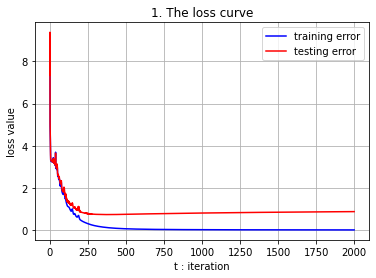

In [8]:
plt.plot(iteration, train_loss_list, c = 'blue')
plt.plot(iteration, test_loss_list, c = 'red')
plt.legend(['training error', 'testing error'])
plt.xlabel('t : iteration')
plt.ylabel('loss value')
plt.title('1. The loss curve')
plt.grid()
plt.show()

### 2. Plotting the accuracy curve
    - Get all training & testing accuracy(%) at every iteration by using defined function.

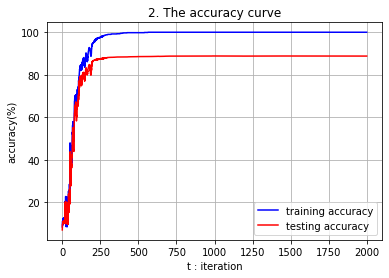

In [9]:
plt.plot(iteration, training_accuracy_list, c = 'blue')
plt.plot(iteration, testing_accuracy_list, c = 'red')
plt.legend(['training accuracy', 'testing accuracy'])
plt.xlabel('t : iteration')
plt.ylabel('accuracy(%)')
plt.title('2. The accuracy curve')
plt.grid()
plt.show()

### 3. Print the accuracy value
    - Print the final training & testing accuracy values.

In [10]:
print('3. The accuracy value')
print('The final training accuracy : ', training_accuracy, '%')
print('The final testing accuracy : ', testing_accuracy, '%')

3. The accuracy value
The final training accuracy :  100.0 %
The final testing accuracy :  88.8 %


### 4. Plotting the classification examples
    - Plot 10 correctly classified testing images.
    - Plot 10 misclassified testing images.

4. Plot the classification example

4 - 1. The correctly classified images


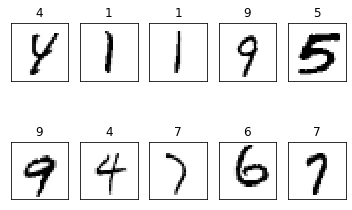

4 - 2. The misclassified images


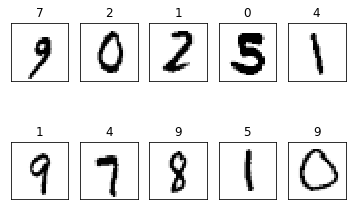

In [11]:
correct_images    = np.empty((size_row * size_col, 10), dtype=float)    #784*10
correct_labels    = np.empty(10, dtype=int)

incorrect_images  = np.empty((size_row * size_col, 10), dtype=float)    #784*10
incorrect_labels    = np.empty(10, dtype=int)

predict_list = predict(h, num_training)

correct_count = 0
incorrect_count = 0

print('4. Plot the classification example')
print()

#make groups of classified images
for i in range(num_testing):
    if predict_list[i] == list_label_testing[i] and correct_count < 10:
        correct_images[:, correct_count] = image_testing[1:, i]
        correct_labels[correct_count] = predict_list[i]
        correct_count += 1
    elif predict_list[i] != list_label_testing[i] and incorrect_count < 10:
        incorrect_images[:, incorrect_count] = image_testing[1:, i]
        incorrect_labels[incorrect_count] = predict_list[i]
        incorrect_count += 1
    elif incorrect_count >= 10 and correct_count >= 10:
        break
        

print('4 - 1. The correctly classified images')

for i in range(correct_count):

    plt.subplot(2, 5, i+1)
    plt.title(correct_labels[i])
    plt.imshow(correct_images[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()
    
print('4 - 2. The misclassified images')

for i in range(incorrect_count):

    plt.subplot(2, 5, i+1)
    plt.title(incorrect_labels[i])
    plt.imshow(incorrect_images[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()
